# Analiza zbioru *Medical Cost Personal* — rozszerzona

Notebook wykonuje: wczytanie danych, kodowanie zmiennych kategorycznych, skalowanie, PCA, analizę odstających, histogramy i zaawansowane wizualizacje.

**Uwaga:** umieść plik `insurance.csv` (z Kaggle) w tym samym folderze co notebook przed uruchomieniem wszystkich komórek.

## 1. Import bibliotek i wczytanie danych

Używamy: `pandas`, `numpy`, `matplotlib`, `scikit-learn`.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Check current directory and list files
print('Current directory:', os.getcwd())
print('\nFiles in current directory:')
print(os.listdir('.'))

# Load dataset (expects insurance.csv in same folder)
csv_path = 'insurance.csv'
if not os.path.exists(csv_path):
    print('\nPlik insurance.csv nie znaleziony. Proszę wrzucić insurance.csv do katalogu z notebookiem i ponownie uruchomić komórkę.')
else:
    df = pd.read_csv(csv_path)
    print('\nDataset loaded:')
    display(df.head())
    print('\nOpis zbioru:')
    display(df.info())
    display(df.describe())

Current directory: C:\Users\jakub\Desktop\ZMUM

Files in current directory:
['.idea', 'data', 'insurance.csv', 'medical_cost_personal_extended.ipynb', 'models', 'README.md', 'requirements.txt']

Dataset loaded:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520



Opis zbioru:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## 2. Sprawdzenie brakujących danych i podstawowa inspekcja

In [2]:
if os.path.exists(csv_path):
    print('Brakujące wartości (suma):')
    display(df.isnull().sum())

    print('\nLiczba duplikatów:')
    print(df.duplicated().sum())

    print('\nUnikalne wartości w kolumnach kategorycznych:')
    for col in ['sex','smoker','region']:
        print(f"- {col}:", df[col].unique())

Brakujące wartości (suma):


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Liczba duplikatów:
1

Unikalne wartości w kolumnach kategorycznych:
- sex: ['female' 'male']
- smoker: ['yes' 'no']
- region: ['southwest' 'southeast' 'northwest' 'northeast']


## 3. Kodowanie zmiennych kategorycznych

Zastosujemy:
- `LabelEncoder` do kolumny `sex` (dwuwartościowa)
- `pd.get_dummies()` (one-hot) do `region`
- `LabelEncoder` do `smoker` (yes/no -> 1/0)

Wynik — `df_encoded` z wartościami numerycznymi.

In [3]:
if os.path.exists(csv_path):
    df_encoded = df.copy()
    le = LabelEncoder()
    df_encoded['sex_enc'] = le.fit_transform(df_encoded['sex'])
    df_encoded['smoker_enc'] = le.fit_transform(df_encoded['smoker'])
    # One-hot for region
    region_dummies = pd.get_dummies(df_encoded['region'], prefix='region', drop_first=True)
    df_encoded = pd.concat([df_encoded.drop(columns=['sex','smoker','region']), region_dummies], axis=1)
    print('Encoded dataframe head:')
    display(df_encoded.head())
    print('\nKolumny po enkodowaniu:')
    print(df_encoded.columns.tolist())

Encoded dataframe head:


,age,bmi,children,charges,sex_enc,smoker_enc,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,False,False,True
1,18,33.770,1,1725.55230,1,0,False,True,False
2,28,33.000,3,4449.46200,1,0,False,True,False
3,33,22.705,0,21984.47061,1,0,True,False,False
4,32,28.880,0,3866.85520,1,0,True,False,False



Kolumny po enkodowaniu:
['age', 'bmi', 'children', 'charges', 'sex_enc', 'smoker_enc', 'region_northwest', 'region_southeast', 'region_southwest']


## 4. Korelacje i analiza wpływu cech na koszt (`charges`)

Obliczymy macierz korelacji i sprawdzimy cechy najsilniej skorelowane z `charges`. Porównamy średnie `charges` dla palaczy i niepalaczy oraz dla regionów.

In [4]:
if os.path.exists(csv_path):
    corr = df_encoded.corr()
    # Najważniejsze korelacje względem charges
    corr_with_charges = corr['charges'].abs().sort_values(ascending=False)
    print('Cecha - korelacja bezwzględna z charges:')
    display(corr_with_charges)

    print('\nŚredni koszt (charges) dla palaczy vs niepalących:')
    display(df.groupby('smoker')['charges'].mean())

    print('\nŚredni koszt (charges) w regionach:')
    display(df.groupby('region')['charges'].mean().sort_values(ascending=False))

Cecha - korelacja bezwzględna z charges:


charges             1.000000
smoker_enc          0.787251
age                 0.299008
bmi                 0.198341
region_southeast    0.073982
children            0.067998
sex_enc             0.057292
region_southwest    0.043210
region_northwest    0.039905
Name: charges, dtype: float64


Średni koszt (charges) dla palaczy vs niepalących:


smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64


Średni koszt (charges) w regionach:


region
southeast    14735.411438
northeast    13406.384516
northwest    12417.575374
southwest    12346.937377
Name: charges, dtype: float64

## 5. Skalowanie cech

Zastosujemy StandardScaler i MinMaxScaler — pokażemy porównanie przed i po skalowaniu dla wybranych cech (`age`, `bmi`, `children`, `charges` jako przykład).

In [5]:
if os.path.exists(csv_path):
    numeric_cols = ['age','bmi','children','charges']
    scaler_std = StandardScaler()
    scaler_mm = MinMaxScaler()
    scaled_std = scaler_std.fit_transform(df[numeric_cols])
    scaled_mm = scaler_mm.fit_transform(df[numeric_cols])
    df_scaled_std = pd.DataFrame(scaled_std, columns=[c+'_std' for c in numeric_cols])
    df_scaled_mm = pd.DataFrame(scaled_mm, columns=[c+'_mm' for c in numeric_cols])
    display(pd.concat([df[numeric_cols].head(), df_scaled_std.head(), df_scaled_mm.head()], axis=1))

,age,bmi,children,charges,age_std,bmi_std,children_std,charges_std,age_mm,bmi_mm,children_mm,charges_mm
0,19,27.900,0,16884.92400,-1.438764,-0.453320,-0.908614,0.298584,0.021739,0.321227,0.0,0.251611
1,18,33.770,1,1725.55230,-1.509965,0.509621,-0.078767,-0.953689,0.000000,0.479150,0.2,0.009636
2,28,33.000,3,4449.46200,-0.797954,0.383307,1.580926,-0.728675,0.217391,0.458434,0.6,0.053115
3,33,22.705,0,21984.47061,-0.441948,-1.305531,-0.908614,0.719843,0.326087,0.181464,0.0,0.333010
4,32,28.880,0,3866.85520,-0.513149,-0.292556,-0.908614,-0.776802,0.304348,0.347592,0.0,0.043816


## 6. Wykrywanie wartości odstających

Użyjemy wykresów boxplot i metody IQR (interquartile range) do znalezienia odstających punktów dla `charges`. Zaznaczymy ile obserwacji jest poza limitem.

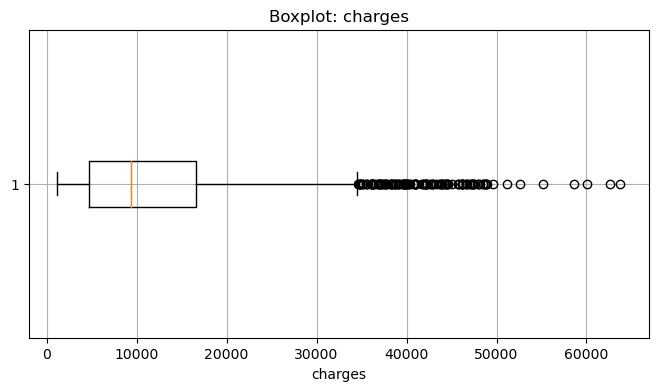

Q1=4740.29, Q3=16639.91, IQR=11899.63
Lower bound=-13109.15, Upper bound=34489.35
Liczba obserwacji odstających (IQR): 139


,age,sex,bmi,children,smoker,region,charges
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768
29,31,male,36.30,2,yes,southwest,38711.0000
30,22,male,35.60,0,yes,southwest,35585.5760


In [6]:
if os.path.exists(csv_path):
    # Boxplot dla charges
    plt.figure(figsize=(8,4))
    plt.boxplot(df['charges'], vert=False)
    plt.title('Boxplot: charges')
    plt.xlabel('charges')
    plt.grid(True)
    plt.show()

    # IQR method
    Q1 = df['charges'].quantile(0.25)
    Q3 = df['charges'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df['charges'] < lower) | (df['charges'] > upper)]
    print(f'Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}')
    print(f'Lower bound={lower:.2f}, Upper bound={upper:.2f}')
    print('Liczba obserwacji odstających (IQR):', len(outliers))
    display(outliers.head())

## 7. Histogramy i rozkłady

Rysujemy histogramy `charges`, `bmi`, `age` oraz porównanie palaczy vs niepalących. Uwaga: każdy wykres używa matplotlib (jeden wykres na komórkę).

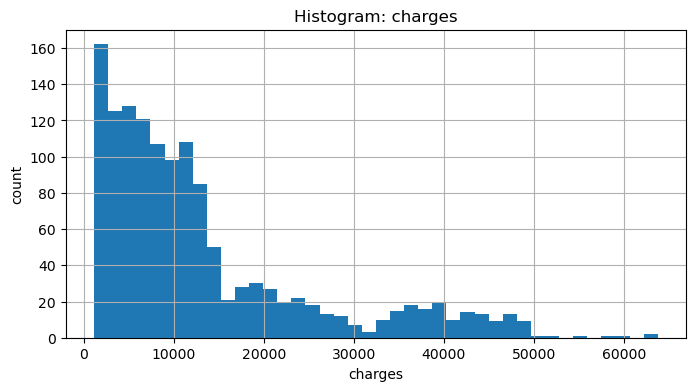

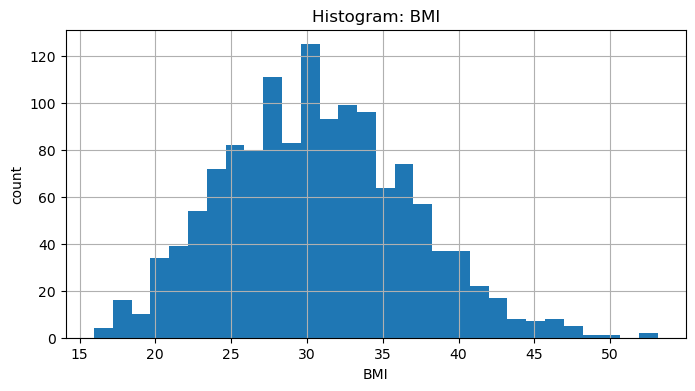

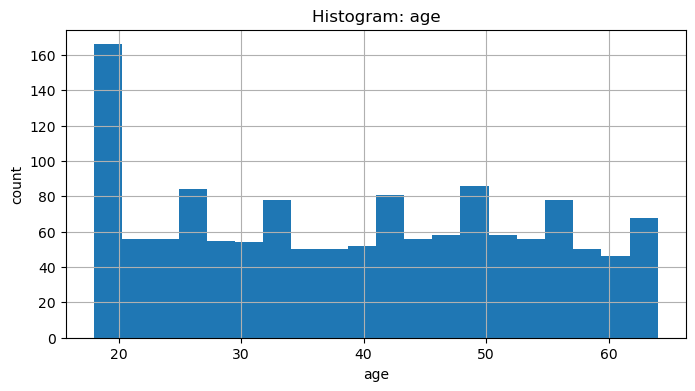

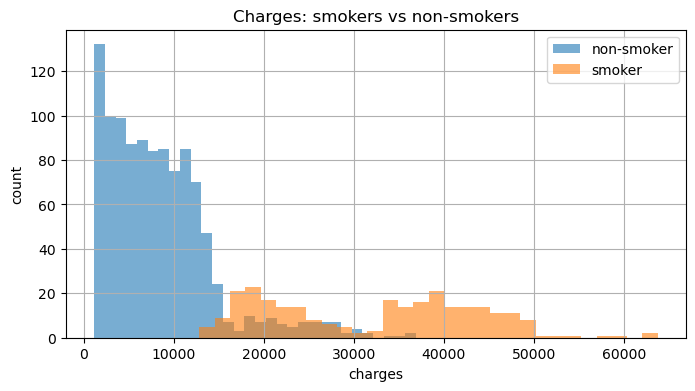

In [7]:
if os.path.exists(csv_path):
    # charges histogram
    plt.figure(figsize=(8,4))
    plt.hist(df['charges'], bins=40)
    plt.title('Histogram: charges')
    plt.xlabel('charges')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

    # bmi histogram
    plt.figure(figsize=(8,4))
    plt.hist(df['bmi'], bins=30)
    plt.title('Histogram: BMI')
    plt.xlabel('BMI')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

    # age histogram
    plt.figure(figsize=(8,4))
    plt.hist(df['age'], bins=20)
    plt.title('Histogram: age')
    plt.xlabel('age')
    plt.ylabel('count')
    plt.grid(True)
    plt.show()

    # charges by smoker (two histograms overlayed as separate plots)
    smokers = df[df['smoker']=='yes']['charges']
    nonsmokers = df[df['smoker']=='no']['charges']

    plt.figure(figsize=(8,4))
    plt.hist(nonsmokers, bins=30, alpha=0.6, label='non-smoker')
    plt.hist(smokers, bins=30, alpha=0.6, label='smoker')
    plt.title('Charges: smokers vs non-smokers')
    plt.xlabel('charges')
    plt.ylabel('count')
    plt.legend()
    plt.grid(True)
    plt.show()

## 8. Zaawansowany wykres — macierz rozrzutu (scatter matrix) + wykresy pudełkowe

Zamiast `seaborn.pairplot` użyjemy `pandas.plotting.scatter_matrix` oraz dodatkowo wykresy pudełkowe rozdzielone po `smoker` i `region`.

<Figure size 1000x1000 with 0 Axes>

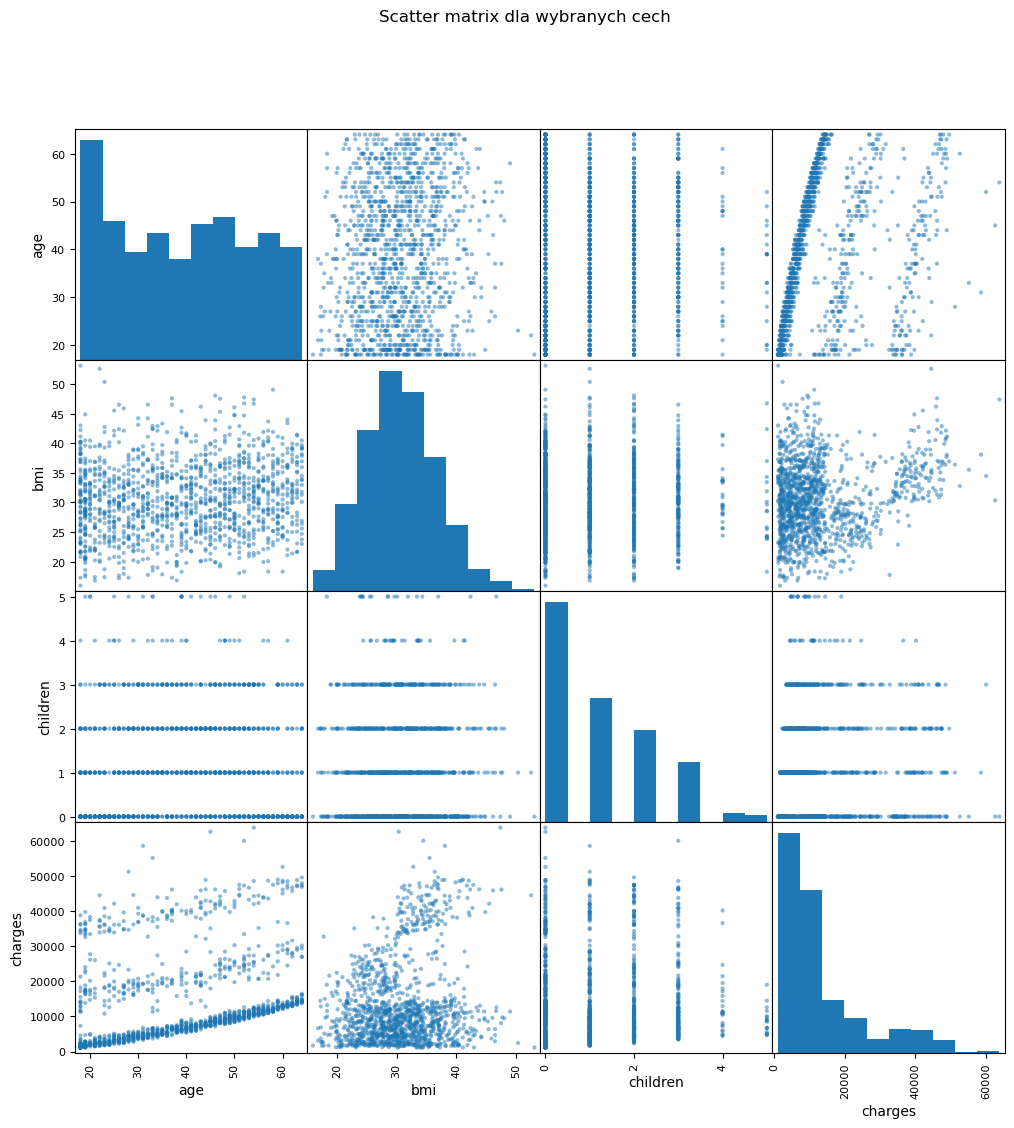

<Figure size 1000x600 with 0 Axes>

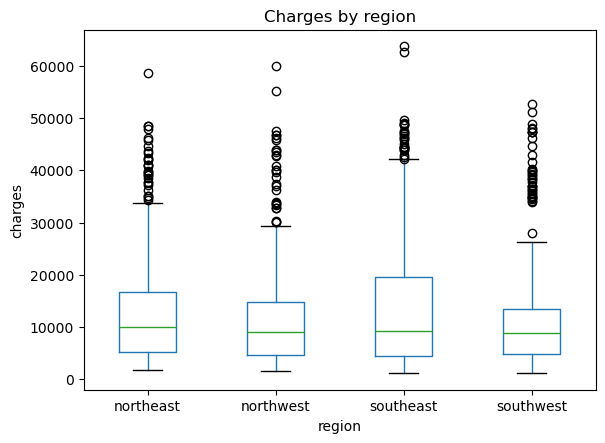

<Figure size 600x400 with 0 Axes>

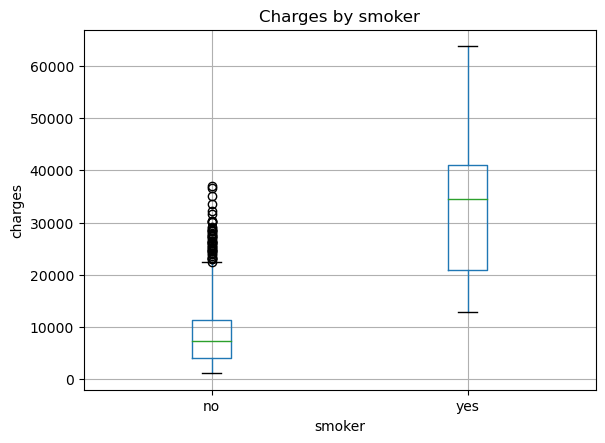

In [8]:
from pandas.plotting import scatter_matrix

if os.path.exists(csv_path):
    features = ['age','bmi','children','charges']
    plt.figure(figsize=(10,10))
    scatter_matrix(df[features], figsize=(12,12), diagonal='hist')
    plt.suptitle('Scatter matrix dla wybranych cech')
    plt.show()

    # Boxplots charges by region and smoker
    regions = df['region'].unique()
    plt.figure(figsize=(10,6))
    df.boxplot(column='charges', by='region', grid=False)
    plt.title('Charges by region')
    plt.suptitle('')
    plt.xlabel('region')
    plt.ylabel('charges')
    plt.show()

    # Boxplot charges by smoker
    plt.figure(figsize=(6,4))
    df.boxplot(column='charges', by='smoker')
    plt.title('Charges by smoker')
    plt.suptitle('')
    plt.xlabel('smoker')
    plt.ylabel('charges')
    plt.show()

## 9. PCA — redukcja wymiarowości i wizualizacja

Zrobimy PCA na zbiorze zakodowanym (`df_encoded`) (po skalowaniu) i wyświetlimy pierwsze 2 główne składowe, kolorując punkty wg `smoker`.

Wyjaśniona wariancja przez 2 składniki: [0.22518081 0.21762111]


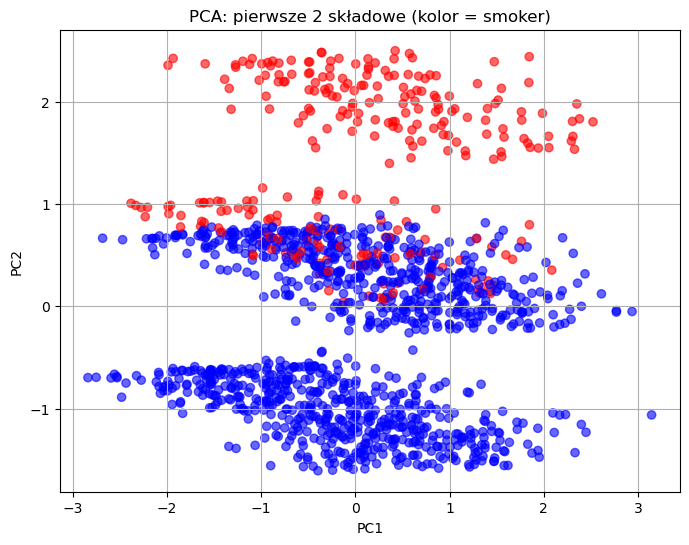

In [9]:
if os.path.exists(csv_path):
    # przygotowanie danych: weźmiemy wszystkie kolumny numeryczne poza charges (możemy też uwzględnić charges jeśli chcemy analizować zależności)
    X = df_encoded.drop(columns=['charges']).select_dtypes(include=[np.number])
    # skalowanie
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    print('Wyjaśniona wariancja przez 2 składniki:', pca.explained_variance_ratio_)

    plt.figure(figsize=(8,6))
    # color by smoker
    colors = df['smoker'].map({'yes': 'red', 'no': 'blue'})
    plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, alpha=0.6)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA: pierwsze 2 składowe (kolor = smoker)')
    plt.grid(True)
    plt.show()

## 10. Krótkie wnioski (do rozwinięcia w raporcie)

- Palenie (`smoker`) ma największy wpływ na `charges`.
- Występują obserwacje odstające w `charges` (wysokie koszty). Można je rozważyć do analizy oddzielnej lub traktować jako realne przypadki.
- PCA pokazuje, że dane częściowo grupują się według statusu palenia.

---

To jest pełny, rozszerzony notebook — możesz teraz go pobrać i uruchomić lokalnie. Jeśli chcesz, mogę też wykonać analizę tu (uruchomić komórki) — ale potrzebuję pliku `insurance.csv` w katalogu.